# Multi Order Coverage data structure to plan multi-messenger observations

The tutorial is associated to the article **[Multi Order Coverage data structure to plan
multi-messenger observations](https://www.journals.elsevier.com/astronomy-and-computing)** under review from **[Astronomy and Computing](https://www.journals.elsevier.com/astronomy-and-computing)**.

### 1. Testing and evaluating algorithm

We show the essential steps to delimit portions of a sky region, encoding with a MOC (Multi Order Coverage) data structure, that are observable from a speciﬁc astronomical site within a ﬁxed time interval and a deﬁned range of airmass values. 
For the first example, we build an elementary MOC and, then, we describe the essential algorithm and perform basic tests.

The tutorial is tested in Python 3.8.5 with the module versions: [mocpy 0.10.0](https://cds-astro.github.io/mocpy/#), [cdshealpix 0.6.1](https://cds-astro.github.io/cds-healpix-python/), [astropy 5.0](https://pypi.org/project/astropy/), [astroplan 0.8](https://pypi.org/project/astroplan/), [ipyaladin 0.1.9](https://github.com/cds-astro/ipyaladin) and [healpy](https://pypi.org/project/healpy/).

In [1]:
!pip3  install  "mocpy==0.10.0" "cdshealpix==0.6.1" "astropy==5.0" "astroplan==0.8" "ipyaladin==0.1.9" "healpy==1.15.0" --user

In [2]:
# For ipyladin

#Then, make sure to enable widgetsnbextension:
!jupyter nbextension enable --py --sys-prefix ipyaladin
#Finally, enable ipyaladin:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension ipyaladin/extension...
      - Validating: OK
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
import json
from datetime import datetime , timedelta
import numpy as np

from mocpy import MOC, STMOC
from cdshealpix import healpix_to_skycoord

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.table import QTable

from astroplan import Observer

from astropy.samp import SAMPIntegratedClient

Matplotlib created a temporary config/cache directory at /var/folders/5n/cq85zsfj29q5_nvkjg9l0b4c0000gn/T/matplotlib-gmsvqvtx because the default path (/Users/gius/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Firstly, we create a MOC region with the HEALPix index = 652 at order = 4 applying the method [from_healpix_cells](https://cds-astro.github.io/mocpy/stubs/mocpy.MOC.html#mocpy.MOC.from_healpix_cells) from mocpy.

In [4]:
%time
ipix = np.array([652], dtype='uint64')
depth = np.array([4], dtype='uint8')

moc_test = MOC.from_healpix_cells(ipix, depth)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.05 µs


Then, we write the MOC region in an external file named **TEST.fits** serialized in a FITS format. **Figure 1** shows the HEALPix grid at the order = 4. In red, the created MOC region **TEST.fits** is depicted.

In [5]:
%time
moc_test.write("TEST.fits", format='fits', overwrite=True)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


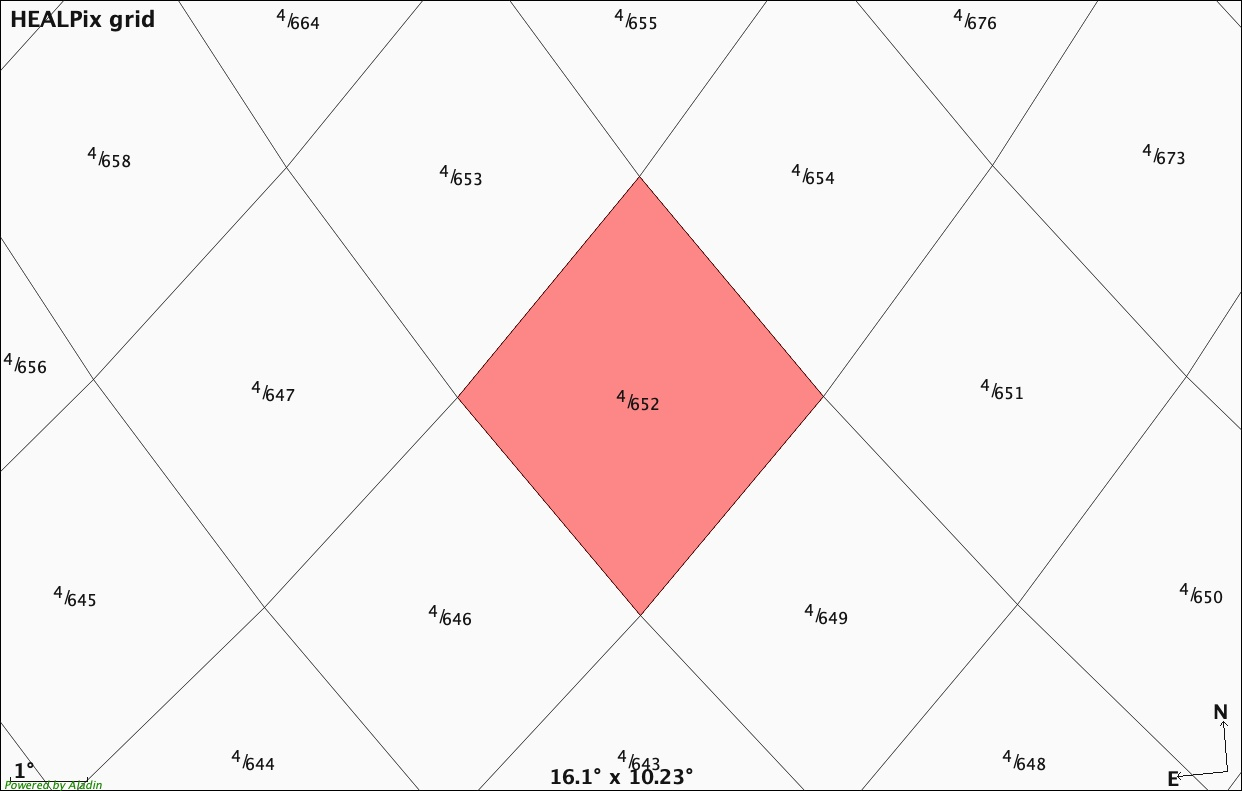

In [6]:
from IPython import display
display.Image("https://raw.githubusercontent.com/ggreco77/Multi-Order-Coverage-data-structure-to-plan-multi-messenger-observations/main/plots/Fig1.jpg")

**Figure 1.** HEALPix grid at order = 4. In red, the MOC region with HEALPix index = 652 created for the test.

Now, we read the MOC file **TEST.fits** and we find the MOC order: the depth of the smallest HEALPix cells. Of course, we will find an order = 4 as set in our MOC creation.

In [7]:
%time
# Read  MOC map.
moc = MOC.from_fits("TEST.fits")

# Find MOC order
moc_order = moc.max_order
print('moc_order =', moc_order)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs
moc_order = 4


Here, we serialize the MOC from fits to json/dictionary with the keys and values representing the orders and the pixel indices, respectively. Of course, in our case we will find a dictionary with key = 4 and value = 652, both data used in the original MOC creation.

In [8]:
%time
# Serialize the MOC from fits to json/dict.
moc_json = moc.serialize(format = "json")
moc_json

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


{'4': [652]}

Next, we want to increase the MOC order from 4 to 5 and to calculate the associated HEALPix indexes at that order. MOC uses the [NESTED](https://healpix.jpl.nasa.gov/html/intronode4.htm) numbering scheme and, thus, each spatial MOC cell can be
stored as one single  interval ranging from $[npix \times 4^{(max\_order - order)}]$ to 
$[(npix+1) \times 4^{(max\_order - order)}-1] $.

#### **You need to set a new MOC order greater than or equal to the order defined in the original MOC**. 

In [9]:
# Set a new MOC order: new MOC order >= original MOC order.
new_order = 5

In [10]:
%time
# Init. a list of HEALPix indices.
healpix_indices = []

# Read MOC JSON file.
for key, value in moc_json.items():
    order = int(key)
    
    # Flatten cells.
    for npix in value:
        first_index = npix*4**(new_order - moc_order)
        last_index = (npix+1)*4**(new_order - moc_order)-1
        
        # Resulting list of flatten cells.
        for healpix_index in np.arange(first_index, last_index+1):
            healpix_indices.append(healpix_index)
            
healpix_indices

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


[2608, 2609, 2610, 2611]

**Figure 2** shows the  HEALPix grid at the order = 5. In red, the selected MOC region is depicted. You can visualize the HEALPix indices: 2608, 2609, 2610, 2611 as calculated in our code.
When the entire collection of cells in a MOC map is 
computed at the same
order, we invoke from cds-healpix-python module the [healpix to skycoord](https://cds-astro.github.io/cds-healpix-python/stubs/cdshealpix.nested.healpix_to_skycoord.html#cdshealpix.nested.healpix_to_skycoord)
method.

This method converts HEALPix indices to celestial coordinates.
The input is a 1-D array of HEALPix indices and the resulting celestial coordinates
are returned in a [SkyCoord](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html#:~:text=High%2Dlevel%20object%20providing%20a,coordinate%20values%20with%20unambiguous%20units) high-level object as defined in astropy.
They are the sky coordinates of the center of the HEALPix cells and marked with a circle in **Figure 2**.

In [11]:
skycoords = healpix_to_skycoord(healpix_indices, new_order)
skycoords

<SkyCoord (ICRS): (ra, dec) in deg
    [(202.5    , 31.38816646), (203.90625, 32.7971683 ),
     (201.09375, 32.7971683 ), (202.5    , 34.22886633)]>

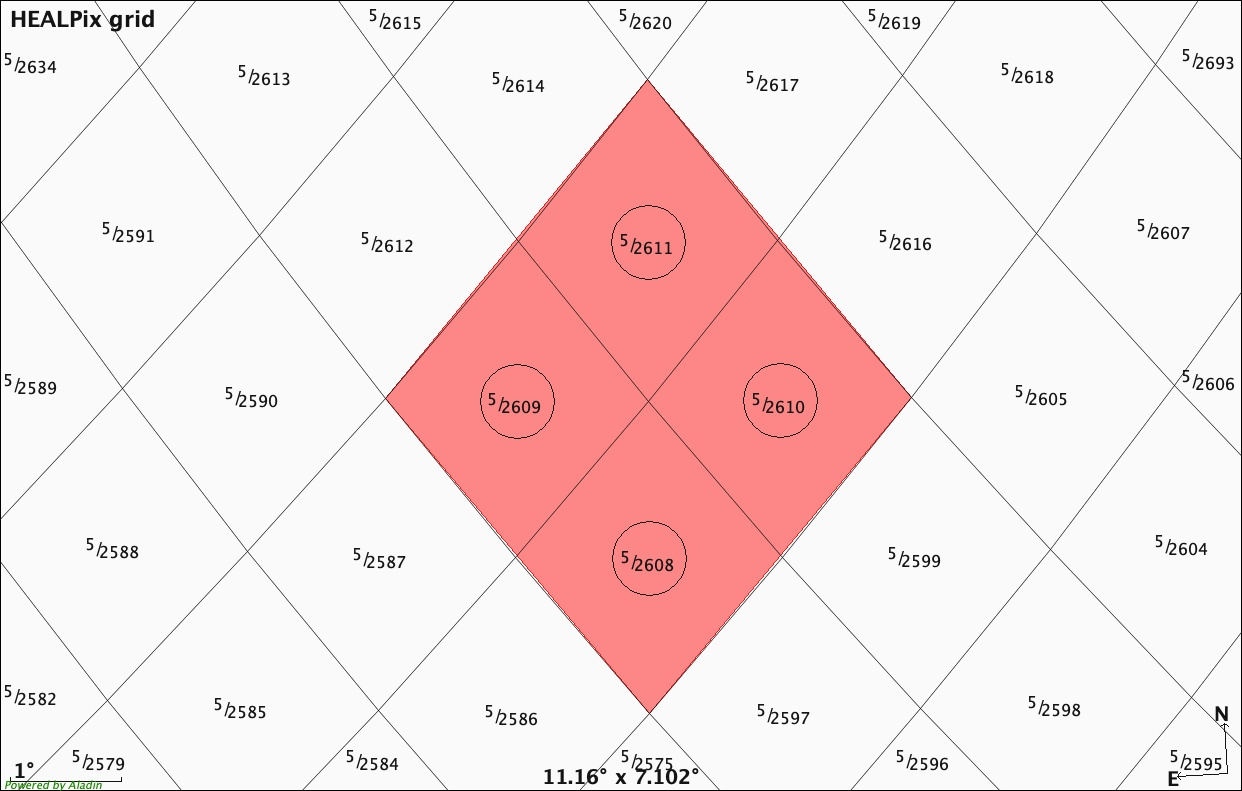

In [12]:
from IPython import display
display.Image("https://raw.githubusercontent.com/ggreco77/Multi-Order-Coverage-data-structure-to-plan-multi-messenger-observations/main/plots/Fig2.jpg")

**Figure 2.**. HEALPix grid at order = 5 with the HEALPix indices, 2608, 2609, 2610, 2611. They are the same indices as provided by our code. The sky coordinates of the center of the HEALPix cells are marked with circles. The sky coordinates are computed by the [healpix to skycoord](https://cds-astro.github.io/cds-healpix-python/stubs/cdshealpix.nested.healpix_to_skycoord.html#cdshealpix.nested.healpix_to_skycoord) method in cdshealpix.

You can interactively visualize the results with the following Aladin widget adding the HEALPix grid from the `Manage Layers` <img src="https://github.com/ggreco77/Tutotest/blob/main/images/ipyaladin_layer.png?raw=true" alt="the Layer Button" style="width:30px; display: inline-block;"/> by checking **HEALPix grid**.

In [13]:
%time
import ipyaladin as ipyal
aladin= ipyal.Aladin(target='13:29:59.9947023, +32:47:54.490452', fov=35)
aladin

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


Aladin(fov=35.0, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'o…

In [14]:
moc_test = {"5":[2608, 2609, 2610, 2611]}
aladin.add_moc_from_dict(moc_test, {'color': 'red', 'opacity': 0.4,
                              'adaptativeDisplay': False, 'name': 'TEST'})

Here, we want to define the airmass in each HEALPix index using astroplan module. In particular, we define the airmass in the Haleakala site  at 2019-04-25 14:18:05.018 UTC.

In [15]:
%time
# Set Observer: Haleakala.
haleakala = Observer.at_site ("haleakala")

# Set observational time.
start_time = Time('2019-04-25 12:30:00')

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.29 µs


Haleakala info from Observer class in astroplan.

In [16]:
haleakala

<Observer: name='haleakala',
    location (lon, lat, el)=(-156.169 deg, 20.71552 deg, 3047.9999999999245 m),
    timezone=<UTC>>

Is night at Haleakala at that time? You can answer it using [is_night](https://astroplan.readthedocs.io/en/latest/api/astroplan.Observer.html#astroplan.Observer.is_night) method in astroplan and setting the astronomical twilight.

In [17]:
%time
# Check if it is night in Haleakala at that time:
# -18 degree horizon (evening astronomical twilight).
night = haleakala.is_night(start_time, horizon = -18*u.deg)
print('Is night?', night)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs
Is night? True


We have all the information to calculate the airmass.

In [18]:
%time
# Airmass calculation
airmass_values = haleakala.altaz(start_time, skycoords).secz
    
for airmass_value, skycoord in zip(airmass_values, skycoords):
    print("airmass:", airmass_value.round(2), skycoord)
    print()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
airmass: 1.28 <SkyCoord (ICRS): (ra, dec) in deg
    (202.5, 31.38816646)>

airmass: 1.27 <SkyCoord (ICRS): (ra, dec) in deg
    (203.90625, 32.7971683)>

airmass: 1.31 <SkyCoord (ICRS): (ra, dec) in deg
    (201.09375, 32.7971683)>

airmass: 1.29 <SkyCoord (ICRS): (ra, dec) in deg
    (202.5, 34.22886633)>



Finally, we want only to select a sky area with airmass < 1.30. Thus, we create a new MOC with those sky coordinates in that airmass. We will call it **MOC observability**. 

It can be useful to create an astropy table with skycoords and airmass_values as columns. Then we filter the airmass_values column from 1.00 to 1.30. 

In [19]:
%time
# Create Astropy table.
#from astropy.table import QTable

tb = QTable([skycoords, airmass_values],
            names = ["skycoords", "airmass_values"])
    
# Mask table with selected airmass values.
mask1 = tb["airmass_values"] >=1.00
tb = tb[mask1]
mask2 = tb["airmass_values"] <=1.30
tb = tb[mask2]
tb

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.77 µs


<QTable length=3>
         skycoords             airmass_values  
          deg,deg                              
          SkyCoord                float64      
---------------------------- ------------------
    202.5,31.388166464348547 1.2833562535594878
203.90625,32.797168295823646  1.265523827316121
     202.5,34.22886632781258 1.2898750955356981

We invoke [from_skycoords](https://cds-astro.github.io/mocpy/stubs/mocpy.MOC.html#mocpy.MOC.from_skycoords) method in mocpy and write the MOC observability in an output file named **moc_observability_haleakala**.

In [20]:
# MOC from  sky coordinates 
moc_observability_haleakala = MOC.from_skycoords(tb["skycoords"], new_order)

# Write MOC in fits
moc_observability_haleakala.write("moc_observability_haleakala", format="fits", overwrite=True)

The MOC observability is shown in green in **Figure 3** over the original MOC. The HEALPix index = 2610 at order = 5 is not considered in the MOC visibility at the coordinates RA [deg] = 201.09375, DEC [deg] = 32.7971683. In fact the associated airmass value = 1.31 is outside the airmass range selected to create the MOC visibility from Haleakala.

In [21]:
# Sky position of HEALPix index = 2610 at order = 5.
skycoord = healpix_to_skycoord(2610, 5)
skycoord

<SkyCoord (ICRS): (ra, dec) in deg
    [(201.09375, 32.7971683)]>

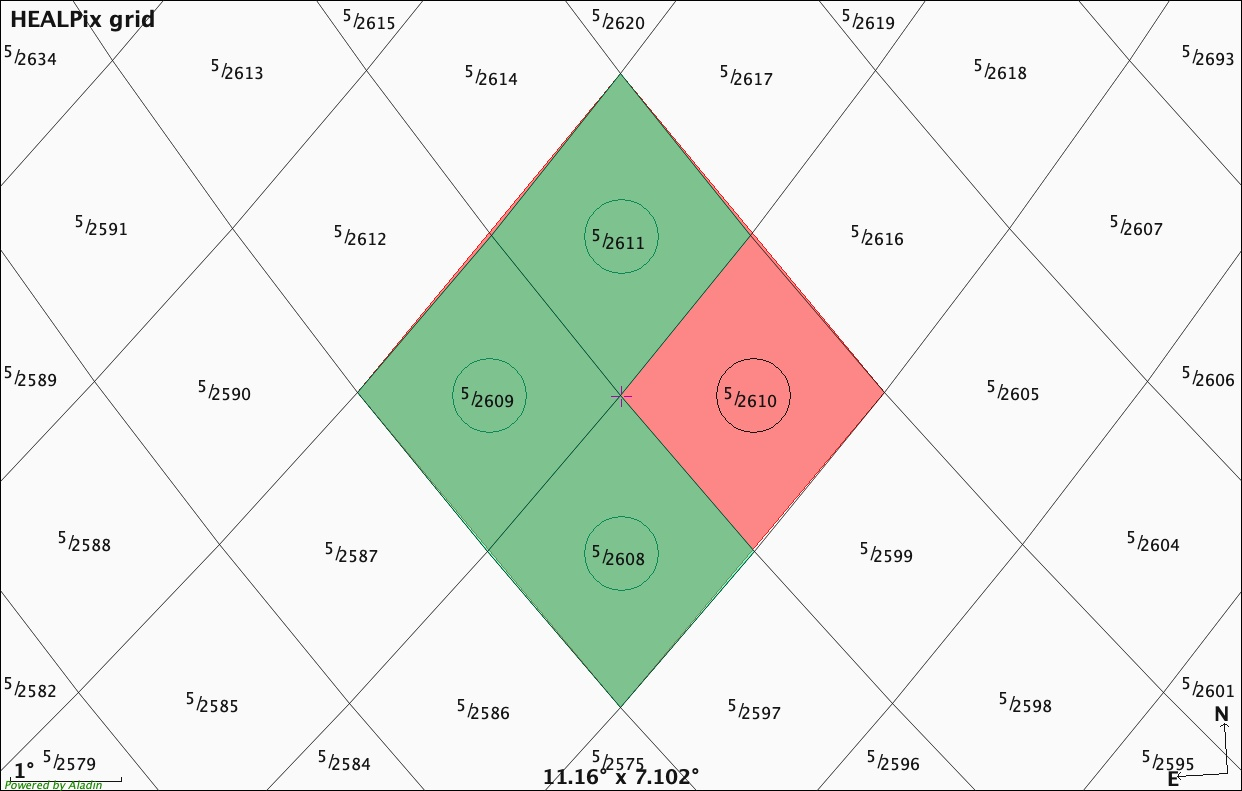

In [22]:
display.Image("https://raw.githubusercontent.com/ggreco77/Multi-Order-Coverage-data-structure-to-plan-multi-messenger-observations/main/plots/Fig3.jpg")

**Figure 3**. In green, the MOC visibility from the Haleakala site with airmass ranges from 1.00 to 1.20 over the original MOC area in red. For an interactive visualization, you can run the code below and use the Aladin widget initialized at the beginning of the tutorial.

In [23]:
moc_obsevability = {"5":[2608, 2609, 2611]}
aladin.add_moc_from_dict(moc_obsevability, {'color': 'green', 'opacity': 0.7,
                              'adaptativeDisplay': False, 'name': 'MOC observability'})

## 1.2. Adding temporal information to an (Observability) MOC
The ability to transform any spatial MOC generated from telescope footprints, image surveys, catalogues, gravitational-wave sky localizations, MOC visibility etc. into spatial and temporal MOC (STMOC) offers several interoperable approaches. In the next sections, we will discuss how to filter candidate transients.

To encode temporal information in a space (observability) MOC, we apply the method [from_spatial_coverages](https://cds-astro.github.io/mocpy/stubs/mocpy.STMOC.html#mocpy.STMOC.from_spatial_coverages) in mocpy. We assume an exposure time of 10 minutes: from 2019-04-25 12:30:00 to 2019-04-25 12:40:00.

In [24]:
# Create a Space and Time MOC from a space MOC.
space_time_moc_obs = STMOC.from_spatial_coverages(Time(['2019-04-25 12:30:00']), 
                                                  Time(['2019-04-25 12:40:00']),
                                                  [moc_observability_haleakala])

# Write space and time MOC
space_time_moc_obs.write("space_time_moc_obs", overwrite=True)

### 1.2.1. Filtering transient candidates

To filter transient candidates *in space and in time* simultaneously, we use the [contains](https://cds-astro.github.io/mocpy/stubs/mocpy.MOC.html#mocpy.MOC.contains) method in mocpy. It returns a boolean mask array of the positions lying inside (or outside) the MOC instance. Good performances are obtained thanks to the core functions written in Rust programming language.  

We consider two transients at the sky positions of t1: (RA [deg] = 202.49997, DEC [deg] = 32.79846) and t2 = (RA [deg] = 202.69392, DEC [deg] = 34.02011) observed at the UTC, 2019-04-25T12:33:00 and 2019-04-25T12:50:00, respectively. Both candidate transients fall inside our MOC region but only the first one is consistent with the exposure time of that region. 

In [25]:
# An astropy table with the 2 transients is created.
transient_tb = QTable()

# ID candidate transients
transient_tb['ID'] =['t1', 't2']

# Transient positions
transient_tb['ra'] = [202.49997, 202.69392]*u.deg
transient_tb['dec'] = [ 32.79846,  34.02011]*u.deg

# Transient time observations
transient_tb['time'] = Time(['2019-04-25T12:33:00', '2019-04-25T13:45:00'])

print(transient_tb)

 ID     ra      dec              time         
       deg      deg                           
--- --------- -------- -----------------------
 t1 202.49997 32.79846 2019-04-25T12:33:00.000
 t2 202.69392 34.02011 2019-04-25T13:45:00.000


In [26]:
# Filtering transients in space and time.
space_time_moc_obs.contains(transient_tb['time'], transient_tb['ra'], transient_tb['dec'])

array([ True, False])

As expected,  the boolean mask returns **True** only for the t1 transient.

# SAMP function
]
We create a function based on [SAMP](https://docs.astropy.org/en/stable/samp/index.html) (Simple Application Messaging Protocol) to visualize the MOC visibility in an Aladin section. 

In [27]:
def send_via_samp (url = "", filename = ""):
    """ Sending MOC file over SAMP.
    
        Parameters
        ----------
        url : str
            URL to the file.
        
        filename : str
            human - readable 315 name for the MOC file.
        
        Returns
        -------
        Transmit a MOC file in tools in which SAMP Hub is running .
    """
    
    client = SAMPIntegratedClient()
    client.connect()
    
    params = {}
    params ["url"] = url+filename
    params ["name"] = filename
    
    message = {}
    message["samp.mtype"] = "image.load.fits"
    message["samp.params"] = params
    
    client.notify_all(message)
    client.disconnect()

# Create  MOC visibilities

Here we describe the essential steps to delimit portions of a MOC coverage that are observable from a specific astronomical site within a fixed time interval and a defined range of airmass values. We start with the 90% credible region of the gravitational-wave event GW190425. The credible region is encoded in a MOC data structure. In order to show the potential of MOCs to manage complex and irregular sky areas, the 90% credible region of GW190425 is prepocessed as discussed in **Sections 4.2 and 4.3**.
The MOC region is accessible from the link [here](https://github.com/ggreco77/MOC-to-plan-MMA/blob/main/data/processed_moc_skymap.fits?raw=true). 
All steps are shown in the [video tutorial](https://virgo.pg.infn.it/sites/virgo.pg.infn.it/files/mm/tuto_A_C_mid.mp4) focusing in the main Aladin graphical user interface. 

For running the code, we consider the merger time of GW190425 from the image's header.

In [28]:
# Download the initial (BAYESTAR)sky map of GW190425 from GraceDB.
!curl -O https://gracedb.ligo.org/api/superevents/S190425z/files/bayestar.fits.gz,0

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  669k  100  669k    0     0    99k      0  0:00:06  0:00:06 --:--:--  160k


In [29]:
%time
# Get merger time from image's header.
import healpy as hp
header = hp.read_map("bayestar.fits.gz,0", h=True)

header = dict(header[1])
merger_time = Time(header['DATE-OBS'])
print('The merger time is', merger_time)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 30.8 µs
The merger time is 2019-04-25T08:18:05.018


In [30]:
# Define an observatory from the astroplan list
observatory_name = 'haleakala'

In [31]:
%time
# Define observatory in the astroplan Observer class
observatory_astroplan_observer = Observer.at_site (observatory_name)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.05 µs


In [32]:
observatory_astroplan_observer

<Observer: name='haleakala',
    location (lon, lat, el)=(-156.169 deg, 20.71552 deg, 3047.9999999999245 m),
    timezone=<UTC>>

In [33]:
%time
# Check if it is night in your Observatory at the merger time:
# -18 degree horizon (evening astronomical twilight).
night = observatory_astroplan_observer.is_night(merger_time, horizon = -18*u.deg)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [34]:
print('Is night in '+observatory_name+'?', night)

Is night in haleakala? True


If it is night in your observatory, we set as start time the merger time of the event, otherwise, we find the nearest twilight astronomical evening. 

In [35]:
%time
if night != False:
    start_time = merger_time
else:
    # Nearest twilight astronomical evening.
    twilight_evening_astronomical = \
    observatory_astroplan_observer.twilight_evening_astronomical(merger_time, 
                                            which ="nearest")
    start_time = twilight_evening_astronomical

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


In [36]:
print('Start time for the first observation:', start_time)

Start time for the first observation: 2019-04-25T08:18:05.018


In [37]:
# Init. list for schedule observation
observatory_time_obs = []

In [38]:
# Set the airmass range to create the MOC visibility
airmass_max = 2
airmass_min = 1

In [39]:
# Load the MOC map processed as in Section 4.2 and 4.3.

from astropy.utils.data import download_file
processed_moc_skymap = download_file("https://github.com/ggreco77/MOC-to-plan-MMA/blob/main/data/processed_moc_skymap.fits?raw=true", 
              cache=True)

In [40]:
%time
# Read the MOC map.
moc = MOC.from_fits(processed_moc_skymap)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [41]:
%time
# Find MOC Order
order = moc.max_order
print('MOC order:', order)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs
MOC order: 11


Here, we want to calculate the visibility area within the previous MOC from the specific observatory site, at a given time and setting the airmass values.

In [42]:
%time
# Serialize the MOC from fits to json/dict.
moc_json = moc.serialize(format = "json")

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.05 µs


In [43]:
# Init. a list of HEALPix indices.
healpix_indices = []

In [44]:
%%time
# Set a MOC order. MOC order >= max order in the original MOC.
input_order = order
print('input_order: ', input_order)

input_order:  11
CPU times: user 136 µs, sys: 68 µs, total: 204 µs
Wall time: 156 µs


In [45]:
%%time
# Read MOC JSON file.
for key, value in moc_json.items():
    order = int(key)
    
    # Flatten cells.
    for npix in value:
        first_index = npix*4**(input_order - order)
        last_index = (npix+1)*4**(input_order - order)-1
        
        # Resulting list of flatten cells.
        for healpix_index in np.arange(first_index, last_index +1):
            healpix_indices.append(healpix_index)

CPU times: user 970 ms, sys: 97.9 ms, total: 1.07 s
Wall time: 1.07 s


In [46]:
%%time
# Convert HEALPix indices to celestial coordinates.
healpix_indices = np.array(healpix_indices)
skycoord = healpix_to_skycoord(healpix_indices, input_order)

CPU times: user 1.27 s, sys: 200 ms, total: 1.47 s
Wall time: 1.04 s


In [47]:
%%time
# Constrain airmass values in time steps.
for h in range (0, 8, 2):
    time_step = start_time + timedelta(hours = h)
    
    night = observatory_astroplan_observer.is_night(time_step, horizon = -18*u.deg)    
    print('Is night in '+observatory_name+'@'+time_step.iso+' ? ',night)

    observatory_time_obs.append(time_step)
    
    # Airmass calculation
    airmass = observatory_astroplan_observer.altaz(time_step, skycoord).secz
    
    # Create an Astropy table.
    tb = QTable([skycoord, airmass],
                names = ["skycoord", "airmass"])
    
    # Mask table with selected airmass values.
    mask1 = tb["airmass"] >=airmass_min
    tb = tb[mask1]
    mask2 = tb["airmass"] <=airmass_max
    tb = tb[mask2]
    
    # Create an observability MOC.
    if len(tb)!=0:
        # Create a Space MOC.
        space_moc = MOC.from_skycoords(tb["skycoord"], 
                                       input_order)

        # Set url and output filenames.
        pwd = !pwd
        url = "file:/"+pwd[0]+'/'
        space_moc_filename = "MOC_"+observatory_name+"@"+time_step.iso

        # Write Space MOC in a FITS format.
        space_moc.write(space_moc_filename, 
                        overwrite = "true")

        # Transmit via SAMP the visibility MOC when it is night (we run Aladin Desktop).
        try:
            if night==True:
                send_via_samp(url, space_moc_filename)
        except:
            print()
            print("Launch Aladin Desktop as reported in the README to visualize the results:")
            print("https://github.com/ggreco77/MOC-to-plan-MMA#aladin-desktop-software")
            print()

        # Write table with columns: SkyCoords and airmass for testing.
        #tb.write("Table_"+observatory_name+"@"+ str(time_step.iso),
        #         format = "fits", overwrite = "true")
    else:
        print("Empty table to create Visibility MOC.")

Is night in haleakala@2019-04-25 08:18:05.018 ?  True
Is night in haleakala@2019-04-25 10:18:05.018 ?  True
Is night in haleakala@2019-04-25 12:18:05.018 ?  True
Is night in haleakala@2019-04-25 14:18:05.018 ?  True
CPU times: user 16.1 s, sys: 2.49 s, total: 18.5 s
Wall time: 59.9 s


Then, we repeat the same steps for Paranal and SSO observatories fixing the same starting time used in the Haleakala site.

In [48]:
# Set Observers: Paranal and SSO
paranal = Observer.at_site ("paranal")
sso = Observer.at_site ("sso")
print(paranal)
print(sso)

<Observer: name='paranal',
    location (lon, lat, el)=(-70.40498688000002 deg, -24.627439409999997 deg, 2668.999999999649 m),
    timezone=<UTC>>
<Observer: name='sso',
    location (lon, lat, el)=(149.06119444444445 deg, -31.273361111111114 deg, 1149.000000001551 m),
    timezone=<UTC>>


**An updated list of built-in observatories can be found in [astropy-data/coordinates/sites.json](https://github.com/astropy/astropy-data/blob/162e724509fd18b8bc3fc29f766b716ce4657d20/coordinates/sites.json)**